In [1]:
# Locals
import oggm.cfg as cfg
import geopandas as gpd
from oggm import utils, workflow, tasks, graphics

# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WORKFLOW', future=True)
rgi_version = '62'

cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 2
cfg.PARAMS['dl_verify'] = False

rgi_ids = ['RGI60-16.02539']

# RGI glaciers
rgi_ids = gpd.read_file(utils.get_rgi_region_file('16'))

2022-07-20 13:54:34: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-07-20 13:54:34: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-07-20 13:54:34: oggm.cfg: Multiprocessing: using all available processors (N=32)
2022-07-20 13:54:34: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2022-07-20 13:54:34: oggm.cfg: Multiprocessing switched ON after user settings.
2022-07-20 13:54:34: oggm.cfg: Multiprocessing: using the requested number of processors (N=2)
2022-07-20 13:54:34: oggm.cfg: PARAMS['dl_verify'] changed from `True` to `False`.


In [2]:
len(rgi_ids)

2939

In [3]:
# Geometrical centerline
# Where to store the data
cfg.PATHS['working_dir'] = utils.mkdir('OGGM_16/', reset=True)

In [4]:
# Go - get the pre-processed glacier directories
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=2, prepro_base_url=base_url)

2022-07-20 13:54:37: oggm.workflow: init_glacier_directories from prepro level 2 on 2939 glaciers.
2022-07-20 13:54:37: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2939 glaciers
/home/users/fmaussion/.miniconda3/envs/oggm_env_20200608/lib/python3.9/site-packages/salem/datasets.py:171: RuntimeWarning: x0 out of bounds
  warnings.warn('x0 out of bounds', RuntimeWarning)
/home/users/fmaussion/.miniconda3/envs/oggm_env_20200608/lib/python3.9/site-packages/salem/datasets.py:171: RuntimeWarning: x0 out of bounds
  warnings.warn('x0 out of bounds', RuntimeWarning)
/home/users/fmaussion/.miniconda3/envs/oggm_env_20200608/lib/python3.9/site-packages/salem/datasets.py:171: RuntimeWarning: x0 out of bounds
  warnings.warn('x0 out of bounds', RuntimeWarning)
/home/users/fmaussion/.miniconda3/envs/oggm_env_20200608/lib/python3.9/site-packages/salem/datasets.py:171: RuntimeWarning: x0 out of bounds
  warnings.warn('x0 out of bounds', RuntimeWarning)
/home/users/fmaussion/.miniconda3/en

In [ ]:
# gdirs = workflow.init_glacier_directories(rgi_ids)

In [5]:
print('Done')

Done


In [6]:
from oggm.shop.millan22 import add_millan_thickness
workflow.execute_entity_task(add_millan_thickness, gdirs);

2022-07-20 13:56:07: oggm.workflow: Execute entity tasks [add_millan_thickness] on 2939 glaciers


In [35]:
import xarray as xr
import numpy as np
import pandas as pd
import progressbar

0.016

In [65]:
odf = pd.DataFrame()
for gdir in progressbar.progressbar(gdirs):
    odf.loc[gdir.rgi_id, 'rgi_area_km2'] = gdir.rgi_area_km2
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        if 'millan_ice_thickness' not in ds:
            odf.loc[gdir.rgi_id, 'millan_vol_km3'] = np.NaN
            odf.loc[gdir.rgi_id, 'millan_area_km2'] = 0
            odf.loc[gdir.rgi_id, 'perc_cov'] = 0
            continue
        thick = ds.millan_ice_thickness.where(ds.glacier_mask, np.NaN).load()
        odf.loc[gdir.rgi_id, 'millan_vol_km3'] = thick.sum() * gdir.grid.dx**2 * 1e-9
        odf.loc[gdir.rgi_id, 'millan_area_km2'] = (~thick.isnull()).sum() * gdir.grid.dx**2 * 1e-6
        odf.loc[gdir.rgi_id, 'perc_cov'] = odf.loc[gdir.rgi_id, 'millan_area_km2'] / gdir.rgi_area_km2

100% (2939 of 2939) |####################| Elapsed Time: 0:01:15 Time:  0:01:15


In [39]:
odf = odf.fillna(0)

In [40]:
#  	2039.8200 	72.157018
odf.sum()

millan_vol_km3       69.063594
millan_area_km2    1953.406538
perc_cov           1798.739867
dtype: float64

From the total volume we need to correct by:

In [41]:
72.157018 / 69.063594

1.0447909502074277

In [42]:
odf['millan_vol_km3_cor'] = odf['millan_vol_km3'] * 72.157018 / 69.063594

In [43]:
odf.sum()

millan_vol_km3          69.063594
millan_area_km2       1953.406538
perc_cov              1798.739867
millan_vol_km3_cor      72.157018
dtype: float64

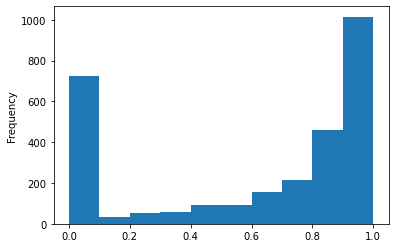

In [46]:
fdf = pd.read_hdf('/home/www/oggm/g2ti/rgi62_era5_itmix_df.h5')
fdf['rgi_reg'] = [s.split('-')[1].split('.')[0] for s in fdf.index]

In [48]:
fdf

CenLon   CenLat  era5_avg_pcp   Area  era5_avg_temp_at_zmed  \
RGIId                                                                           
RGI60-01.00001 -146.8230  63.6890    763.129312  0.360             -12.130729   
RGI60-01.00002 -146.6680  63.4040    801.464239  0.558             -10.550402   
RGI60-01.00003 -146.0800  63.3760    823.346929  1.685              -9.567049   
RGI60-01.00004 -146.1200  63.3810    823.346929  3.681             -10.061049   
RGI60-01.00005 -147.0570  63.5510    871.860850  2.573              -9.365849   
...                  ...      ...           ...    ...                    ...   
RGI60-19.02748  -37.7325 -53.9860   1121.466184  0.042               8.030344   
RGI60-19.02749  -36.1361 -54.8310   1505.146630  0.567               7.204056   
RGI60-19.02750  -37.3018 -54.1884   1264.378020  4.118               7.943137   
RGI60-19.02751  -90.4266 -68.8656    667.099859  0.011               1.584250   
RGI60-19.02752   37.7140 -46.8972   1205.984800  0.528              12.359629   

                Zmed  vol_bsl_itmix_m3  vol_itmix_m3  era5_trend rgi_reg  
RGIId                                                                     
RGI60-01.00001  2385           0.00000  7.638771e+06    0.144383      01  
RGI60-01.00002  2005           0.00000  1.697646e+07    0.159570      01  
RGI60-01.00003  1868           0.00000  5.969346e+07    0.133943      01  
RGI60-01.00004  1944           0.00000  1.952248e+08    0.133943      01  
RGI60-01.00005  1914           0.00000  1.221541e+08    0.170513      01  
...              ...               ...           ...         ...     ...  
RGI60-19.02748  -999           0.00000  5.502906e+05    0.086660      19  
RGI60-19.02749  -999           0.00000  1.300672e+07    0.129571      19  
RGI60-19.02750  -999      359846.64917  2.506893e+08    0.105411      19  
RGI60-19.02751  -999           0.00000  1.068206e+05   -0.095884      19  
RGI60-19.02752  -999           0.00000  1.489316e+07    0.006869      19  

[216502 rows x 10 columns]

In [49]:
odf['f19_vol_km3'] = fdf['vol_itmix_m3'] * 1e-9

In [55]:
ss = odf.sum()
ss

millan_vol_km3          69.063594
millan_area_km2       1953.406538
perc_cov              1798.739867
millan_vol_km3_cor      72.157018
f19_vol_km3             98.363146
dtype: float64

In [58]:
ss['millan_vol_km3_cor'] / ss['f19_vol_km3'] - 1

-0.266422224584831

In [62]:
ss = odf.loc[odf.perc_cov > 0.8].sum()
ss

millan_vol_km3          68.481680
millan_area_km2       1901.407432
perc_cov              1397.817642
millan_vol_km3_cor      71.549039
f19_vol_km3             85.721461
dtype: float64

In [60]:
ss['millan_vol_km3_cor'] / ss['f19_vol_km3'] - 1

-0.16533107815653092

In [61]:
ss = odf.loc[odf.perc_cov > 0.9].sum()
ss['millan_vol_km3_cor'] / ss['f19_vol_km3'] - 1

-0.15815383449422526

In [63]:
sel = odf.loc[odf.perc_cov > 0.8]

In [64]:
sel.plot.scatter(x='f19_vol_km3')

millan_vol_km3  millan_area_km2  perc_cov  millan_vol_km3_cor  \
RGI60-16.00216        0.091013         2.865724  0.948287            0.095090   
RGI60-16.00218        0.039486         1.927800  0.981568            0.041255   
RGI60-16.00219        0.001578         0.200277  0.890120            0.001649   
RGI60-16.00221        0.002982         0.243627  0.889150            0.003116   
RGI60-16.00222        0.007042         0.450400  0.970690            0.007358   
...                        ...              ...       ...                 ...   
RGI60-16.02884        0.002133         0.323095  0.834871            0.002228   
RGI60-16.02942        0.043271         1.493520  0.954936            0.045209   
RGI60-16.02943        0.006216         0.244783  1.007337            0.006494   
RGI60-16.02944        0.329236         8.991609  0.963008            0.343983   
RGI60-16.02945        0.060902         2.469888  0.977786            0.063630   

                f19_vol_km3  
RGI60-16.00216     0.106108  
RGI60-16.00218     0.050802  
RGI60-16.00219     0.005468  
RGI60-16.00221     0.005050  
RGI60-16.00222     0.015978  
...                     ...  
RGI60-16.02884     0.010547  
RGI60-16.02942     0.056698  
RGI60-16.02943     0.005517  
RGI60-16.02944     0.528070  
RGI60-16.02945     0.100562  

[1509 rows x 5 columns]